In [1]:
import Pkg; 
Pkg.activate(@__DIR__); 
Pkg.instantiate()

  Activating environment at `~/Documents/PhD/courses/16745_optimal_control_rl/project/ballbot_ocrl_navigation/Project.toml`


In [2]:
#Pkg.add("ForwardDiff")
#Pkg.add("PyPlot")
#Pkg.add("RobotDynamics")
#Pkg.add("Ipopt")
#Pkg.add("MathOptInterface")
#Pkg.add("FileIO")
#Pkg.add("JLD2")
#Pkg.add("ECOS")
#Pkg.add("Convex")
#Pkg.add("FiniteDiff")

In [2]:
using RigidBodyDynamics
using LinearAlgebra
using StaticArrays
using MeshCat
using MeshCatMechanisms
using ForwardDiff
using PyPlot
using RobotDynamics
using Ipopt
import ECOS
import Convex as cvx
import MathOptInterface as MOI
using FileIO, JLD2;

import MeshCat as mc

WebIO._IJuliaInit()

In [3]:
include(joinpath(@__DIR__, "utils","fmincon.jl"))
include(joinpath(@__DIR__, "utils","ballbot_model.jl"))

rk4 (generic function with 1 method)

## Load ballbot model

In [4]:
ballbot_model = Ballbot()
#ballbot_model_no_arms = Ballbot_arms()

Ballbot{StateCache{Float64, TypeSortedCollections.TypeSortedCollection{Tuple{Vector{Joint{Float64, Prismatic{Float64}}}, Vector{Joint{Float64, Revolute{Float64}}}}, 2}}}(Spanning tree:
Vertex: world (root)
  Vertex: Link_Xtran, Edge: Joint_World_Xtran
    Vertex: Link_Ytran, Edge: Joint_World_Ytran
      Vertex: Link_Pitch, Edge: xAngle
        Vertex: Link_Roll, Edge: yAngle
          Vertex: Link_Yaw, Edge: yaw
No non-tree joints., StateCache{…}(…), DynamicsResultCache{Float64}(…), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

## Start visualizer

In [5]:
# Initialize visualizer
vis = Visualizer()

# Render visualizer
render(vis)

# Create visualizer for ballbot
delete!(vis)
mvis = MechanismVisualizer(ballbot_model.mech, URDFVisuals(urdf), vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8719


MechanismVisualizer{MechanismState{Float64, Float64, Float64, TypeSortedCollections.TypeSortedCollection{Tuple{Vector{Joint{Float64, Prismatic{Float64}}}, Vector{Joint{Float64, Revolute{Float64}}}}, 2}}, Visualizer}(MechanismState{Float64, Float64, Float64, …}(…), MeshCat Visualizer with path /meshcat at http://127.0.0.1:8719, 12)

## Trajectory optimization

In [6]:
function create_idx(nx,nu,N) 
    # Our Z vector is [x0, u0, x1, u1, …, xN]
    nz = (N-1) * nu + N * nx # length of Z 
    x = [(i - 1) * (nx + nu) .+ (1 : nx) for i = 1:N]
    u = [(i - 1) * (nx + nu) .+ ((nx + 1):(nx + nu)) for i = 1:(N - 1)]
    
    # Constraint indexing for the (N-1) dynamics constraints when stacked up
    c = [(i - 1) * (nx) .+ (1 : nx) for i = 1:(N - 1)]
    nc = (N - 1) * nx # (N-1)*nx 
    return (nx=nx,nu=nu,N=N,nz=nz,nc=nc,x=x,u=u,c=c)
end


create_idx (generic function with 1 method)

In [7]:
function hermite_simpson(params::NamedTuple, x1::Vector, x2::Vector, u, dt::Real)::Vector
    # Input hermite simpson implicit integrator residual
    f1 = m_dynamics(ballbot_model, x1, u)
    f2 = m_dynamics(ballbot_model, x2, u)
    xm = 0.5*(x1 + x2) + (dt/8.0)*(f1 - f2)
    fm = m_dynamics(ballbot_model, xm, u)
    r = x1 + (dt/6.0)*(f1 + 4*fm + f2) - x2
    return r
end

hermite_simpson (generic function with 1 method)

In [8]:
function stage_cost(params,x,u,k)
    xref, uref = params.Xref, params.Uref
    Q = params.Q
    R = params.R
    return 0.5*((x-xref[k])'*Q*(x-xref[k])) + 0.5*(u-uref[k])'*R*(u-uref[k])
end

function terminal_cost(params,x)
    Qn = params.Qf
    xref = params.Xref
    return 0.5*((x-xref[end])'*Qn*(x-xref[end]))
end

terminal_cost (generic function with 1 method)

In [9]:
function ballbot_cost(params::NamedTuple, Z::Vector)::Real
    idx, N = params.idx, params.N 
    # Stage cost
    J = 0 
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]]
       
        J += stage_cost(params, xi, ui, i)
    end
    
    # Terminal cost 
    xend = Z[idx.x[end]]
    J += terminal_cost(params, xend)
    return J 
end

ballbot_cost (generic function with 1 method)

In [10]:
function ballbot_dynamics_constraints(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt = params.idx, params.N, params.dt
    c = zeros(eltype(Z), idx.nc)
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]] 
        xip1 = Z[idx.x[i+1]]
        # Apply hermite simpson 
        c[idx.c[i]] .= hermite_simpson(params, xi, xip1, ui, dt)
    end
    return c
end

ballbot_dynamics_constraints (generic function with 1 method)

In [11]:
function ballbot_equality_constraint(params::NamedTuple, Z::Vector)::Vector
    idx, N = params.idx, params.N 
    xg = params.xg
    xic = params.xic
    # Return all of the equality constraints 
    c = ballbot_dynamics_constraints(params, Z)
    c = [c; Z[idx.x[1]] - xic]
    c = [c; Z[idx.x[end]] - xg]

    return c
end

ballbot_equality_constraint (generic function with 1 method)

In [12]:
function ballbot_inequality_constraint(params, Z)
        return zeros(eltype(Z), 0)
    end

ballbot_inequality_constraint (generic function with 1 method)

## Move from point A to point B

In [13]:
# Optimization Parameters
h = 0.1 #10 Hz
nq = 5
nx = nq*2     # number of state
nu = 3     # number of controls
Tfinal = 8.0 # final time
Nt = Int(Tfinal/h)+1   # number of time steps
thist = Array(range(0,h*(Nt-1), step=h));
n_nlp = (nx+nu)*Nt # number of decision variables
m_nlp = nx*(Nt+1)

# Cost terms
diagq = ones(nx)
diagq[1:2] = diagq[1:2]*1 # position cost
diagq[3:4] = diagq[3:4]*1 # lean angles cost

# Cost matrices
Q = diagm(diagq)
Qf = 10*Q
R = 0.5*diagm(ones(nu))

xic = zeros(nx)
xg = zeros(nx)
xg[1] = 8 # x-position
xg[2] = 8 # y-position

# Indexing 
idx = create_idx(nx,nu,Nt);

diff_type = :auto

:auto

In [14]:
# Create warm start trajectory
Xref = range(xic, xg, length = Nt)
Uref = [zeros(3) for i = 1:(Nt-1)];

In [15]:
# Create params
params = (xic = xic,
          xg = xg,
          Xref = Xref,
          Uref = Uref,
          dt = h,
          N = Nt,
          idx = idx,
          Q = Q,
          R = R,
          Qf = Qf);

In [16]:
# Primal bounds 
x_l = ones(idx.nz)
x_u = ones(idx.nz)

for i = 1:(Nt-1)
    x_l[idx.x[i]] .= -Inf*x_l[idx.x[i]]
    x_u[idx.x[i]] .= Inf*x_u[idx.x[i]]
    x_l[idx.u[i]] .= -Inf*x_l[idx.u[i]]
    x_u[idx.u[i]] .= Inf*x_u[idx.u[i]]
end

x_l[idx.x[end]] .= -Inf*x_l[idx.x[end]]
x_u[idx.x[end]] .= Inf*x_u[idx.x[end]]

# Inequality constraint bounds (this is what we do when we have no inequality constraints)
c_l = zeros(0)
c_u = zeros(0)

verbose=true

true

In [17]:
z0 = zeros(idx.nz)
for i in 1:(Nt-1)
    z0[idx.x[i]] .= Xref[i]
    z0[idx.u[i]] .= Uref[i]
end
z0[idx.x[end]] .= Xref[end];

In [18]:
Z = fmincon(ballbot_cost,ballbot_equality_constraint,ballbot_inequality_constraint,
                x_l,x_u,c_l,c_u,z0,params, diff_type;
                tol = 1e-6, c_tol = 1e-6, max_iters = 10_000, verbose = verbose);

---------checking dimensions of everything----------
---------all dimensions good------------------------
---------diff type set to :auto (ForwardDiff.jl)----
---------testing objective gradient-----------------
---------testing constraint Jacobian----------------
---------successfully compiled both derivatives-----
---------IPOPT beginning solve----------------------

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   861000
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian...

In [19]:
# Pull the X and U solutions out of Z 
X = [Z[idx.x[i]] for i = 1:Nt]
U = [Z[idx.u[i]] for i = 1:(Nt-1)];

In [20]:
Xm = hcat(X...)
Um = hcat(U...);

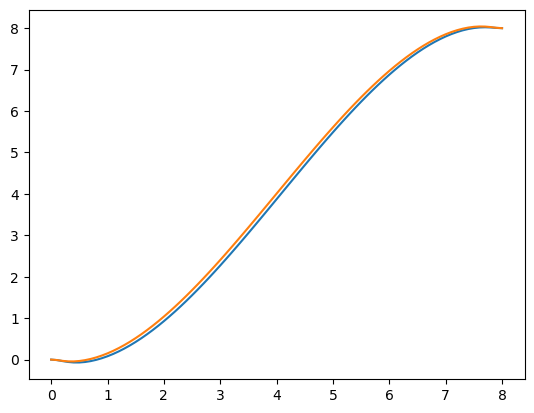

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x158a25cf0>

In [21]:
plot(thist,Xm[1,:])
plot(thist,Xm[2,:])

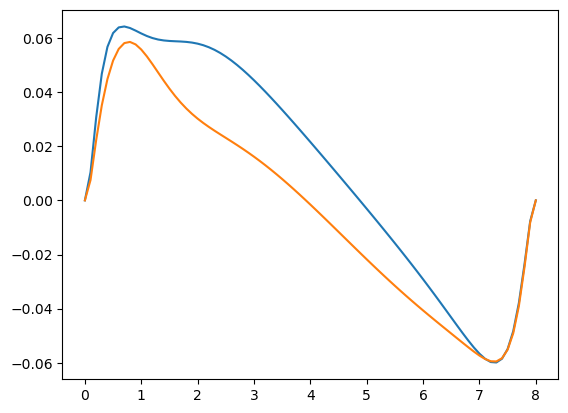

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x15b3627d0>

In [22]:
plot(thist,Xm[3,:])
plot(thist,Xm[4,:])

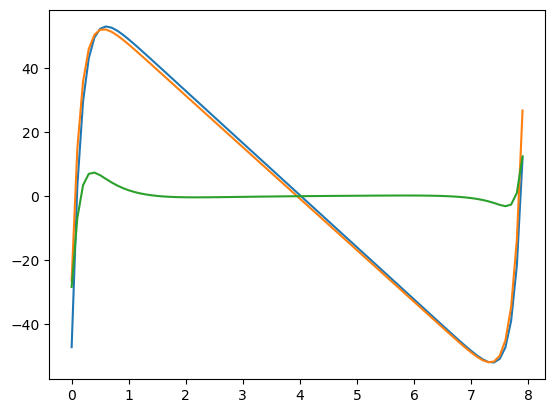

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x15b4fab90>

In [23]:
plot(thist[1:Nt-1],Um[1,:])
plot(thist[1:Nt-1],Um[2,:])
plot(thist[1:Nt-1],Um[3,:])

In [24]:
X1 = [SVector{5}(x[1:5]) for x in X];

In [25]:
animation = Animation(mvis, thist, X1)

Animation(Dict{MeshCat.SceneTrees.Path, MeshCat.AnimationClip}(/meshcat/world/Link_Xtran/Link_Ytran/Link_Pitch/Link_Roll => MeshCat.AnimationClip(Dict{String, MeshCat.AnimationTrack}("position" => MeshCat.AnimationTrack{Vector{Float64}}("position", "vector3", [0 => [0.0, 0.0, 0.0], 1 => [0.0, 0.0, 0.0], 2 => [0.0, 0.0, 0.0], 3 => [0.0, 0.0, 0.0], 4 => [0.0, 0.0, 0.0], 5 => [0.0, 0.0, 0.0], 6 => [0.0, 0.0, 0.0], 7 => [0.0, 0.0, 0.0], 8 => [0.0, 0.0, 0.0], 9 => [0.0, 0.0, 0.0]  …  231 => [0.0, 0.0, 0.0], 232 => [0.0, 0.0, 0.0], 233 => [0.0, 0.0, 0.0], 234 => [0.0, 0.0, 0.0], 235 => [0.0, 0.0, 0.0], 236 => [0.0, 0.0, 0.0], 237 => [0.0, 0.0, 0.0], 238 => [0.0, 0.0, 0.0], 239 => [0.0, 0.0, 0.0], 240 => [0.0, 0.0, 0.0]]), "quaternion" => MeshCat.AnimationTrack{Vector{Float64}}("quaternion", "quaternion", [0 => [0.0, 8.990751968219017e-31, 0.0, 1.0], 1 => [7.606766176092354e-20, 0.0012521591175138377, -2.23500511687388e-22, 0.9999992160484649], 2 => [-5.071286749281944e-21, 0.0025043162717635

In [26]:
# Load simulation to visualizer
setanimation!(mvis, animation)

## Simulation

In [27]:
x0 = [0,0,0,0,0,0,0,0,0,0];
#xcurrent = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

#state = MechanismState(model_with_arms.mech)
#state = MechanismState(model.mech)
#set_configuration!(state, xcurrent)

In [72]:
K_lqr = FileIO.load("utils/ballbot_K_lqr.jld2","K_lqr")

3×10 Matrix{Float64}:
 -65.9132     -0.341245  -1659.61     …  -340.457      -1.0455  -0.137694
  -0.346785  -55.6852       -4.29462       -1.05547  -309.247    4.14736
   1.17922   -35.123        14.8013         3.54713  -105.591    5.20419

In [73]:
# simulate closed loop system 
Xsim = [zeros(nx) for i = 1:Nt]
Usim = [zeros(nx) for i = 1:(Nt-1)]

# initial condition 
Xsim[1] = 1*x0

# DONE: simulate with closed loop control 
for i = 1:(Nt-1) 
    Usim[i] = U[i] - K_lqr*(Xsim[i] - X[i])
    Xsim[i+1] = rk4(ballbot_model, Xsim[i], Usim[i], h)
end

In [74]:
Xm_sim = hcat(Xsim...)
Um_sim = hcat(Usim...)

3×75 Matrix{Float64}:
 -1.70572  -86.8362   -83.9909   …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 -8.56833   68.0899    37.8765      NaN  NaN  NaN  NaN  NaN  NaN  NaN
 -4.38384    4.66808   -3.95659     NaN  NaN  NaN  NaN  NaN  NaN  NaN

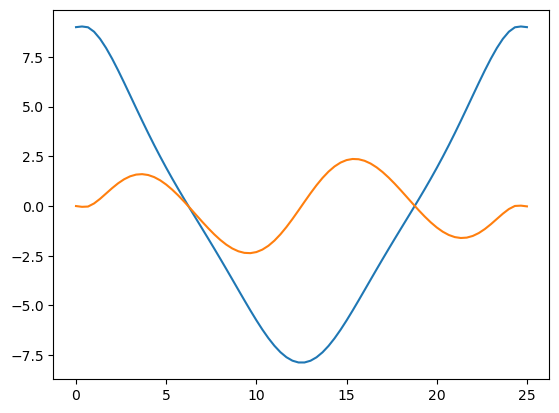

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x15b526920>

In [75]:
plot(thist,Xm[1,:])
plot(thist,Xm[2,:])

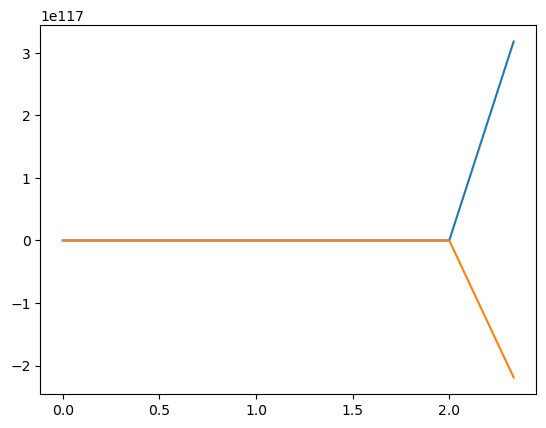

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x15bae0a60>

In [76]:
plot(thist,Xm_sim[1,:])
plot(thist,Xm_sim[2,:])

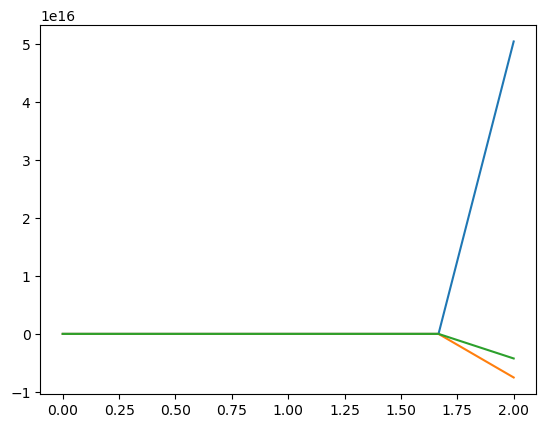

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x15bfe1300>

In [77]:
plot(thist[1:Nt-1],Um_sim[1,:])
plot(thist[1:Nt-1],Um_sim[2,:])
plot(thist[1:Nt-1],Um_sim[3,:])

In [34]:
Xs = [SVector{5}(x[1:5]) for x in Xsim];

In [35]:
animation = Animation(mvis, thist, Xs)

Animation(Dict{MeshCat.SceneTrees.Path, MeshCat.AnimationClip}(/meshcat/world/Link_Xtran/Link_Ytran/Link_Pitch/Link_Roll => MeshCat.AnimationClip(Dict{String, MeshCat.AnimationTrack}("position" => MeshCat.AnimationTrack{Vector{Float64}}("position", "vector3", [0 => [0.0, 0.0, 0.0], 1 => [0.0, 0.0, 0.0], 2 => [0.0, 0.0, 0.0], 3 => [0.0, 0.0, 0.0], 4 => [0.0, 0.0, 0.0], 5 => [0.0, 0.0, 0.0], 6 => [0.0, 0.0, 0.0], 7 => [0.0, 0.0, 0.0], 8 => [0.0, 0.0, 0.0], 9 => [0.0, 0.0, 0.0]  …  231 => [0.0, 0.0, 0.0], 232 => [0.0, 0.0, 0.0], 233 => [0.0, 0.0, 0.0], 234 => [0.0, 0.0, 0.0], 235 => [0.0, 0.0, 0.0], 236 => [0.0, 0.0, 0.0], 237 => [0.0, 0.0, 0.0], 238 => [0.0, 0.0, 0.0], 239 => [0.0, 0.0, 0.0], 240 => [0.0, 0.0, 0.0]]), "quaternion" => MeshCat.AnimationTrack{Vector{Float64}}("quaternion", "quaternion", [0 => [0.0, 0.0, 0.0, 1.0], 1 => [0.0, 0.0, 0.0, 1.0], 2 => [0.0, 0.0, 0.0, 1.0], 3 => [0.0, 0.0, 0.0, 1.0], 4 => [0.0, 0.0, 0.0, 1.0], 5 => [0.0, 0.0, 0.0, 1.0], 6 => [0.0, 0.0, 0.0, 1.0], 

In [36]:
setanimation!(mvis, animation)

## Create 8-shape trajectory

In [37]:
function create_infinity_shape_traj_t(t, i)
    scale = 18 ./ (3 .- cos.(2*t./i))
    x = scale.*cos.(t./i)
    y = scale.*sin.(2*t./i)/ 2
    return x, y
end

create_infinity_shape_traj_t (generic function with 1 method)

In [38]:
# Optimization Parameters
h = 1/3 #3 Hz
nq = 5
nx = nq*2     # number of state
nu = 3     # number of controls
Tfinal = 25 # final time
Nt = Int(Tfinal/h)+1   # number of time steps
thist = Array(range(0,h*(Nt-1), step=h));
n_nlp = (nx+nu)*Nt # number of decision variables
m_nlp = nx*(Nt+1)

# Cost terms
diagq = ones(nx)
diagq[1:2] = diagq[1:2]*100 # position cost
diagq[3:4] = diagq[3:4]*10# lean angles cost

# Cost matrices
Q = diagm(diagq)
Qf = 100*Q
R = 0.1*diagm(ones(nu))

# indexing 
idx = create_idx(nx,nu,Nt);

diff_type = :auto

:auto

In [39]:
x, y = create_infinity_shape_traj_t(thist, 3.98); #2.4

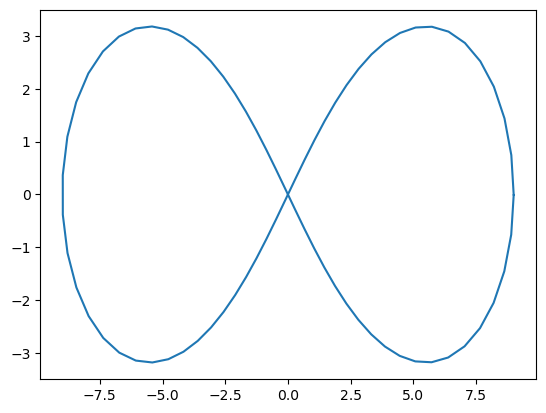

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x15ae15e10>

In [40]:
plot(x, y)

In [41]:
# Create warm start trajectory
Xref = [[x[i]; y[i]; zeros(8)] for i = 1:Nt]
Uref = [zeros(3) for i = 1:(Nt-1)];

In [42]:
xic =  Xref[1]
xg = Xref[end];

In [43]:
# Create params
params = (xic = xic,
          xg = xg,
          Xref = Xref,
          Uref = Uref,
          dt = h,
          N = Nt,
          idx = idx,
          Q = Q,
          R = R,
          Qf = Qf);

In [44]:
# Primal bounds 
x_l = ones(idx.nz)
x_u = ones(idx.nz)

for i = 1:(Nt-1)
    x_l[idx.x[i]] .= -Inf*x_l[idx.x[i]]
    x_u[idx.x[i]] .= Inf*x_u[idx.x[i]]
    x_l[idx.u[i]] .= -Inf*x_l[idx.u[i]]
    x_u[idx.u[i]] .= Inf*x_u[idx.u[i]]
end

x_l[idx.x[end]] .= -Inf*x_l[idx.x[end]]
x_u[idx.x[end]] .= Inf*x_u[idx.x[end]]

# Inequality constraint bounds (this is what we do when we have no inequality constraints)
c_l = zeros(0)
c_u = zeros(0)

verbose=true

true

In [45]:
z0 = zeros(idx.nz)
for i in 1:(Nt-1)
    z0[idx.x[i]] .= Xref[i]
    z0[idx.u[i]] .= Uref[i]
end
z0[idx.x[end]] .= Xref[end];

In [46]:
Z = fmincon(ballbot_cost,ballbot_equality_constraint,ballbot_inequality_constraint,
                x_l,x_u,c_l,c_u,z0,params, diff_type;
                tol = 1e-6, c_tol = 1e-6, max_iters = 10_000, verbose = verbose);

---------checking dimensions of everything----------
---------all dimensions good------------------------
---------diff type set to :auto (ForwardDiff.jl)----
---------testing objective gradient-----------------
---------testing constraint Jacobian----------------
---------successfully compiled both derivatives-----
---------IPOPT beginning solve----------------------
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   758450
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      985
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      770
Total number of inequality constraints.......

In [47]:
# Pull the X and U solutions out of Z 
X = [Z[idx.x[i]] for i = 1:Nt]
U = [Z[idx.u[i]] for i = 1:(Nt-1)];

In [78]:
# save references
#FileIO.save("utils/ballbot_Xref_8_less.jld2","Xref_8_less", X)
#FileIO.save("utils/ballbot_Uref_8_less.jld2","Uref_8_less", U)
#FileIO.save("utils/ballbot_Xref_8_2.jld2","Xref_8_2", X)
#FileIO.save("utils/ballbot_Uref_8_2.jld2","Uref_8_2", U)
FileIO.save("utils/ballbot_Xref_8_big_2.jld2","Xref_8_big_2", X)
FileIO.save("utils/ballbot_Uref_8_big_2.jld2","Uref_8_big_2", U)

In [79]:
#Xref_trajop = FileIO.load("utils/ballbot_Xref_8_less.jld2","Xref_8_less")
#Uref_trajop = FileIO.load("utils/ballbot_Uref_8_less.jld2","Uref_8_less");
#Xref_trajop = FileIO.load("utils/ballbot_Xref_8_2.jld2","Xref_8_2")
#Uref_trajop = FileIO.load("utils/ballbot_Uref_8_2.jld2","Uref_8_2");
Xref_trajop = FileIO.load("utils/ballbot_Xref_8_big_2.jld2","Xref_8_big_2")
Uref_trajop = FileIO.load("utils/ballbot_Uref_8_big_2.jld2","Uref_8_big_2");

In [80]:
Xm = hcat(X...)
Um = hcat(U...);

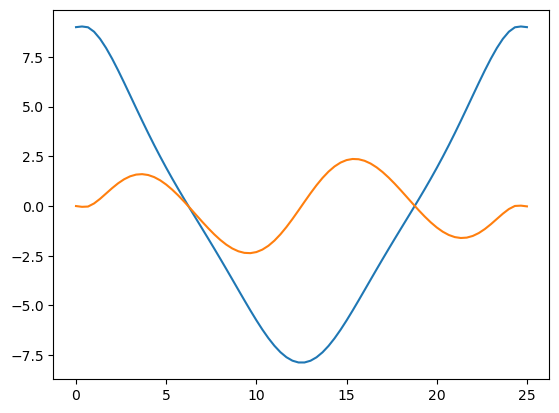

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x15c07d330>

In [81]:
plot(thist,Xm[1,:])
plot(thist,Xm[2,:])

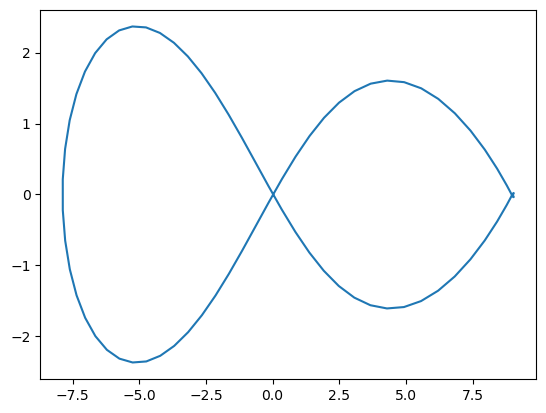

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x15c1e32e0>

In [82]:
plot(Xm[1,:],Xm[2,:])

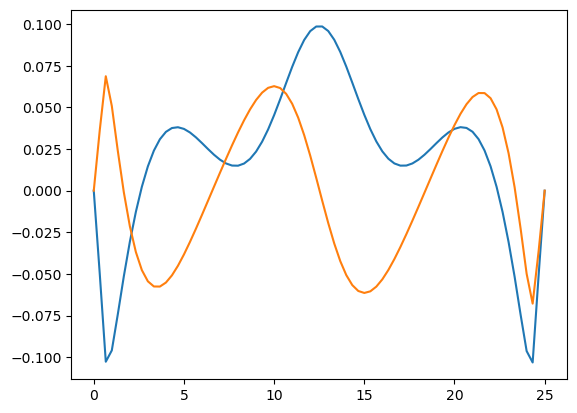

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x15c270df0>

In [83]:
plot(thist,Xm[3,:])
plot(thist,Xm[4,:])

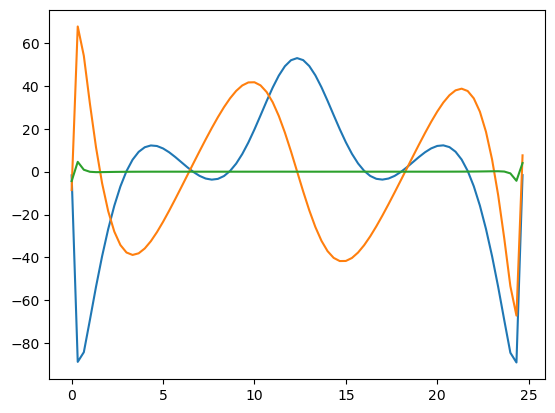

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x15c2fcac0>

In [84]:
plot(thist[1:Nt-1],Um[1,:])
plot(thist[1:Nt-1],Um[2,:])
plot(thist[1:Nt-1],Um[3,:])

In [85]:
X1 = [SVector{5}(x[1:5]) for x in X];

In [86]:
animation = Animation(mvis, thist, X1)

Animation(Dict{MeshCat.SceneTrees.Path, MeshCat.AnimationClip}(/meshcat/world/Link_Xtran/Link_Ytran/Link_Pitch/Link_Roll => MeshCat.AnimationClip(Dict{String, MeshCat.AnimationTrack}("position" => MeshCat.AnimationTrack{Vector{Float64}}("position", "vector3", [0 => [0.0, 0.0, 0.0], 1 => [0.0, 0.0, 0.0], 2 => [0.0, 0.0, 0.0], 3 => [0.0, 0.0, 0.0], 4 => [0.0, 0.0, 0.0], 5 => [0.0, 0.0, 0.0], 6 => [0.0, 0.0, 0.0], 7 => [0.0, 0.0, 0.0], 8 => [0.0, 0.0, 0.0], 9 => [0.0, 0.0, 0.0]  …  741 => [0.0, 0.0, 0.0], 742 => [0.0, 0.0, 0.0], 743 => [0.0, 0.0, 0.0], 744 => [0.0, 0.0, 0.0], 745 => [0.0, 0.0, 0.0], 746 => [0.0, 0.0, 0.0], 747 => [0.0, 0.0, 0.0], 748 => [0.0, 0.0, 0.0], 749 => [0.0, 0.0, 0.0], 750 => [0.0, 0.0, 0.0]]), "quaternion" => MeshCat.AnimationTrack{Vector{Float64}}("quaternion", "quaternion", [0 => [0.0, -6.2276166219743395e-31, 0.0, 1.0], 1 => [7.093832872058253e-20, 0.0018208291632208701, 9.153865024720799e-23, 0.9999983422892051], 2 => [4.668152541878341e-20, 0.003641652289625

In [87]:
# Load simulation to visualizer
setanimation!(mvis, animation)

## Simulation

### TVLQR

In [88]:
function tvlqr(model,
               dt,
               Xbar,
               Ubar,
               Q::Matrix, # cost weight 
               R::Matrix, # cost weight 
               Qf::Matrix,# term cost weight 
               N::Int64   # horizon size 
               )::Tuple{Vector{Matrix{Float64}}, Vector{Matrix{Float64}}} # return two matrices 
        
    # check sizes of everything 
    nx = length(Xbar[1])
    nu = length(Ubar[1])
  
    @assert size(Q) == (nx, nx)
    @assert size(R) == (nu, nu)
    @assert size(Qf) == (nx, nx)
        
    # instantiate S and K 
    P = [zeros(nx,nx) for i = 1:N]
    K = [zeros(nu,nx) for i = 1:N-1]
    
    # initialize S[N] with Qf 
    P[N] = deepcopy(Qf)
    
    # Ricatti 
    for k = (N-1):-1:1
        A = ForwardDiff.jacobian(x->rk4(model, x, Ubar[k], dt), Xbar[k]);
        B = ForwardDiff.jacobian(u->rk4(model, Xbar[k], u, dt), Ubar[k]);
        K[k] = (R + B'*P[k+1]*B)\(B'*P[k+1]*A)
        P[k] = Q + A'*P[k+1]*(A-B*K[k]) 
    end
    
    return P, K 
end

tvlqr (generic function with 1 method)

In [89]:
_, K_tvlqr = tvlqr(ballbot_model, h, Xref_trajop, Uref_trajop, Q, R, Qf, Nt);

In [90]:
#FileIO.save("utils/ballbot_tvlqr_8.jld2","tvlqr_8", U)

In [91]:
x0 = xic*1;

# Initialize simulation 
Xsim = [zeros(nx) for i = 1:Nt]
Usim = [zeros(nx) for i = 1:(Nt-1)]

# Initial condition 
Xsim[1] = 1*x0

# Simulate with closed loop control 
for i = 1:(Nt-1) 
    Usim[i] = Uref_trajop[i] - K_tvlqr[i]*(Xsim[i] - Xref_trajop[i])
    Xsim[i+1] = rk4(ballbot_model, Xsim[i], Usim[i], h)
end

In [92]:
Xm_sim = hcat(Xsim...)
Um_sim = hcat(Usim...)

3×75 Matrix{Float64}:
 -1.70572  -87.89     -76.121     …  -83.8537    -88.3446   -0.268789
 -8.56833   67.9117    46.755        -52.839     -66.4901    8.52983
 -4.38384    4.65897    0.658722      -0.758711   -4.20116   3.97728

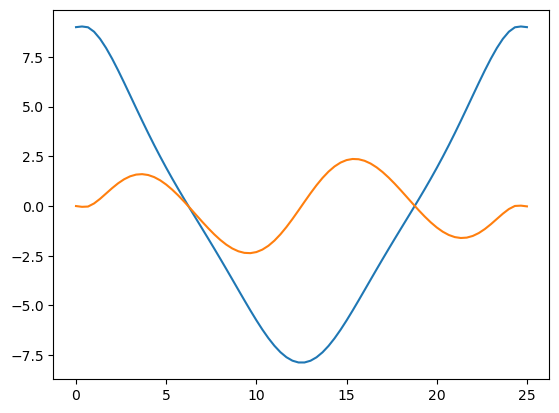

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x15c380eb0>

In [93]:
plot(thist,Xm[1,:])
plot(thist,Xm[2,:])

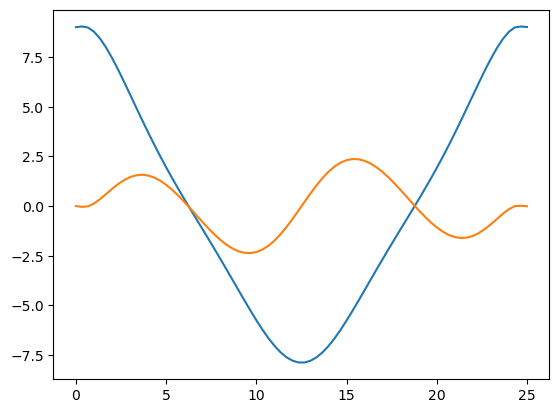

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x15c5df790>

In [94]:
plot(thist,Xm_sim[1,:])
plot(thist,Xm_sim[2,:])

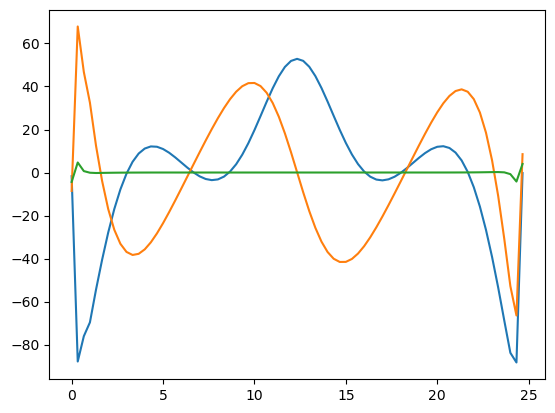

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x15c66dd50>

In [95]:
plot(thist[1:Nt-1],Um_sim[1,:])
plot(thist[1:Nt-1],Um_sim[2,:])
plot(thist[1:Nt-1],Um_sim[3,:])

In [96]:
Xs = [SVector{5}(x[1:5]) for x in Xsim];

In [97]:
function vis_traj!(vis, name, X; R = 0.1, color = mc.RGBA(1.0, 0.0, 0.0, 1.0))
    # visualize a trajectory expressed with X::Vector{Vector}
    #for i = 1:(length(X)-1)
    #    a = [X[i][2]; -X[i][1]; 0.0]
    #    b = [X[i][2]; -X[i+1][1]; 0.0]
    #    cyl = mc.Cylinder(mc.Point(b...), mc.Point(a...), R)
    #    mc.setobject!(vis[name]["p"*string(i)], cyl, mc.MeshPhongMaterial(color=color))
    #end
    for i = 1:length(X)
        a = [X[i][2]; -X[i][1]; 0.0]
        sph = mc.HyperSphere(mc.Point(a...), R)
        mc.setobject!(vis[name]["s"*string(i)], sph, mc.MeshPhongMaterial(color=color))
    end
end

vis_traj! (generic function with 1 method)

In [98]:
vis_traj!(mvis, :traj, Xref_trajop; R = 0.05, color = mc.RGBA(1.0, 0.0, 0.0, 1.0))

In [99]:
animation = Animation(mvis, thist, Xs)

Animation(Dict{MeshCat.SceneTrees.Path, MeshCat.AnimationClip}(/meshcat/world/Link_Xtran/Link_Ytran/Link_Pitch/Link_Roll => MeshCat.AnimationClip(Dict{String, MeshCat.AnimationTrack}("position" => MeshCat.AnimationTrack{Vector{Float64}}("position", "vector3", [0 => [0.0, 0.0, 0.0], 1 => [0.0, 0.0, 0.0], 2 => [0.0, 0.0, 0.0], 3 => [0.0, 0.0, 0.0], 4 => [0.0, 0.0, 0.0], 5 => [0.0, 0.0, 0.0], 6 => [0.0, 0.0, 0.0], 7 => [0.0, 0.0, 0.0], 8 => [0.0, 0.0, 0.0], 9 => [0.0, 0.0, 0.0]  …  741 => [0.0, 0.0, 0.0], 742 => [0.0, 0.0, 0.0], 743 => [0.0, 0.0, 0.0], 744 => [0.0, 0.0, 0.0], 745 => [0.0, 0.0, 0.0], 746 => [0.0, 0.0, 0.0], 747 => [0.0, 0.0, 0.0], 748 => [0.0, 0.0, 0.0], 749 => [0.0, 0.0, 0.0], 750 => [0.0, 0.0, 0.0]]), "quaternion" => MeshCat.AnimationTrack{Vector{Float64}}("quaternion", "quaternion", [0 => [0.0, 0.0, 0.0, 1.0], 1 => [4.244618967889261e-20, 0.0019126864595285283, -3.7435329255007615e-22, 0.9999981708135809], 2 => [1.0727924801513186e-20, 0.003825365921736865, -2.622857039

In [100]:
setanimation!(mvis, animation)